In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from matplotlib import pyplot
import shap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
import gc
import json
pd.set_option('display.max_columns', 1000)

# Objective

* In the last notebook we create our baseline model including a feature selection part. 
* Cohen cappa score of 0.456 (lb) with a local cv score of 0.529
* In this notebook we are going to add more features and remove others that i think they overfitt the train set and then check if our local cv score improve.
* Next, we will check if this improvement aligns with the lb.

# Notes
* Check the distribution of the target variable of the out of folds score and the prediction distribution. A good model should more or less have the same distribution.

In [2]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [3]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [4]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('../data-science-bowl-2019/train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('../data-science-bowl-2019/test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('../data-science-bowl-2019/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('../data-science-bowl-2019/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('../data-science-bowl-2019/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [5]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [6]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
        
    # last features
    sessions_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features['installation_session_count'] = sessions_count
            
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                 
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [7]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [56]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=7, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, loss_score, model

In [57]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100
                    }
        return params

In [58]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'colsample_bytree': 0.8,                 
            'learning_rate': 0.01,
            'max_depth': 10,
            'subsample': 1,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight':3,
            'gamma':0.25,
            'n_estimators':5000}

        return params

In [59]:
class Catb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        clf = CatBoostRegressor(**self.params)
        clf.fit(train_set['X'], 
                train_set['y'], 
                eval_set=(val_set['X'], val_set['y']),
                verbose=verbosity, 
                cat_features=self.categoricals)
        return clf
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        params = {'loss_function': 'RMSE',
                   'task_type': "CPU",
                   'iterations': 5000,
                   'od_type': "Iter",
                    'depth': 10,
                  'colsample_bylevel': 0.5, 
                   'early_stopping_rounds': 300,
                    'l2_leaf_reg': 18,
                   'random_seed': 42,
                    'use_best_model': True,
                  
                    }
        return params

In [60]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

class Nn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.get_feature_names()]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        print(train_df[features].shape)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set['X'].shape[1],)),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='relu')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

In [61]:
from random import choice

class Cnn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.get_feature_names()]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        self.create_feat_2d(features)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def create_feat_2d(self, features, n_feats_repeat=50):
        self.n_feats = len(features)
        self.n_feats_repeat = n_feats_repeat
        self.mask = np.zeros((self.n_feats_repeat, self.n_feats), dtype=np.int32)
        for i in range(self.n_feats_repeat):
            l = list(range(self.n_feats))
            for j in range(self.n_feats):
                c = l.pop(choice(range(len(l))))
                self.mask[i, j] = c
        self.mask = tf.convert_to_tensor(self.mask)
        print(self.mask.shape)
       
        
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0

        inp = tf.keras.layers.Input(shape=(self.n_feats))
        x = tf.keras.layers.Lambda(lambda x: tf.gather(x, self.mask, axis=1))(inp)
        x = tf.keras.layers.Reshape((self.n_feats_repeat, self.n_feats, 1))(x)
        x = tf.keras.layers.Conv2D(18, (50, 50), strides=50, activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(200, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(100, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(50, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        out = tf.keras.layers.Dense(1)(x)
        
        model = tf.keras.Model(inp, out)
    
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

In [14]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode

train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0.0026939774600629332


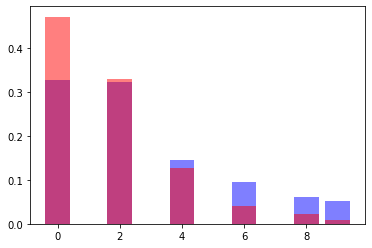

0.0026939774600629332

In [15]:
def stract_hists(feature, train=reduce_train, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre
stract_hists('Magma Peak - Level 1_2000', adjust=False, plot=True)

In [16]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [17]:
counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
            if c > 0.995:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

1: FEAT_A: Clip FEAT_B: 27253bdc - Correlation: 0.9999999999999974
2: FEAT_A: 2050 FEAT_B: 2040 - Correlation: 0.9965259434877979
3: FEAT_A: 2050 FEAT_B: dcaede90 - Correlation: 0.9965259434877979
4: FEAT_A: 2050 FEAT_B: 73757a5e - Correlation: 0.9998050146714084
5: FEAT_A: 2050 FEAT_B: 2b9272f4 - Correlation: 0.9999839030068794
6: FEAT_A: 2050 FEAT_B: 26fd2d99 - Correlation: 0.996508454399599
7: FEAT_A: 2050 FEAT_B: 08fd73f3 - Correlation: 0.9966123918733648
8: FEAT_A: 2050 FEAT_B: 37c53127 - Correlation: 1.0
9: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2030 - Correlation: 0.9966123918733648
10: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2040 - Correlation: 0.9965259434877979
11: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3021 - Correlation: 0.9998050146714084
12: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2050 - Correlation: 1.0
13: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2020 - Correlation: 0.996508454399599
14: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3121 - Correlation: 0.9999839030068794
15: FEAT_A: 3110 FEAT_B: 3010 - Correlation: 

111: FEAT_A: 76babcde FEAT_B: Dino Dive_4070 - Correlation: 1.0
112: FEAT_A: 3edf6747 FEAT_B: Cauldron Filler (Assessment)_4035 - Correlation: 0.9999999999999781
113: FEAT_A: 65a38bf7 FEAT_B: 7ad3efc6 - Correlation: 0.9999786265689903
114: FEAT_A: 65a38bf7 FEAT_B: Cart Balancer (Assessment)_2000 - Correlation: 0.9999786265689903
115: FEAT_A: 65a38bf7 FEAT_B: Cart Balancer (Assessment)_2020 - Correlation: 1.0
116: FEAT_A: 44cb4907 FEAT_B: 8b757ab8 - Correlation: 0.9998350587946221
117: FEAT_A: 44cb4907 FEAT_B: Crystals Rule_3120 - Correlation: 0.9998350587946221
118: FEAT_A: 44cb4907 FEAT_B: Crystals Rule_3020 - Correlation: 1.0
119: FEAT_A: 28520915 FEAT_B: b5053438 - Correlation: 0.9990905166101242
120: FEAT_A: 28520915 FEAT_B: d3268efa - Correlation: 0.9989055023165085
121: FEAT_A: 28520915 FEAT_B: Cauldron Filler (Assessment)_3021 - Correlation: 0.9989055023165085
122: FEAT_A: 28520915 FEAT_B: Cauldron Filler (Assessment)_3121 - Correlation: 0.9990905166101242
123: FEAT_A: 28520915 

214: FEAT_A: 392e14df FEAT_B: Cauldron Filler (Assessment)_4100 - Correlation: 1.0
215: FEAT_A: 47f43a44 FEAT_B: Flower Waterer (Activity)_4090 - Correlation: 0.9999999999999764
216: FEAT_A: 28a4eb9a FEAT_B: 9de5e594 - Correlation: 0.9995923561196854
217: FEAT_A: 28a4eb9a FEAT_B: Dino Dive_3020 - Correlation: 0.9995923561196854
218: FEAT_A: 28a4eb9a FEAT_B: Dino Dive_3120 - Correlation: 0.9999999999999927
219: FEAT_A: 3ddc79c3 FEAT_B: e720d930 - Correlation: 0.9998920962508248
220: FEAT_A: 3ddc79c3 FEAT_B: Crystals Rule_3021 - Correlation: 1.0
221: FEAT_A: 3ddc79c3 FEAT_B: Crystals Rule_3121 - Correlation: 0.9998920962508248
222: FEAT_A: 2a512369 FEAT_B: 33505eae - Correlation: 0.9994585292841485
223: FEAT_A: 2a512369 FEAT_B: Leaf Leader_3110 - Correlation: 0.9999999999999719
224: FEAT_A: 2a512369 FEAT_B: Leaf Leader_3010 - Correlation: 0.9994585292841485
225: FEAT_A: 7da34a02 FEAT_B: Mushroom Sorter (Assessment)_4070 - Correlation: 0.9999999999999301
226: FEAT_A: e37a2b78 FEAT_B: ad2f

318: FEAT_A: b74258a0 FEAT_B: Cart Balancer (Assessment)_2030 - Correlation: 1.0
319: FEAT_A: b74258a0 FEAT_B: Cart Balancer (Assessment)_3121 - Correlation: 1.0
320: FEAT_A: 3d0b9317 FEAT_B: Chest Sorter (Assessment)_4040 - Correlation: 0.9999999999999934
321: FEAT_A: 4e5fc6f5 FEAT_B: Cart Balancer (Assessment)_4090 - Correlation: 0.999999999999939
322: FEAT_A: 63f13dd7 FEAT_B: Chow Time_2020 - Correlation: 1.0
323: FEAT_A: 6088b756 FEAT_B: Dino Dive_2070 - Correlation: 0.999999999999963
324: FEAT_A: 8af75982 FEAT_B: Happy Camel_4020 - Correlation: 0.999999999999996
325: FEAT_A: 00c73085 FEAT_B: Dino Dive_2030 - Correlation: 0.999999999999992
326: FEAT_A: dcb55a27 FEAT_B: Air Show_4110 - Correlation: 1.0
327: FEAT_A: d122731b FEAT_B: Cart Balancer (Assessment)_4100 - Correlation: 1.0
328: FEAT_A: 93edfe2e FEAT_B: Crystals Rule_4090 - Correlation: 0.9999999999999842
329: FEAT_A: 598f4598 FEAT_B: Flower Waterer (Activity)_4025 - Correlation: 0.9999999999999946
330: FEAT_A: c51d8688 FEAT

423: FEAT_A: 15ba1109 FEAT_B: Air Show_2000 - Correlation: 1.0
424: FEAT_A: 9d4e7b25 FEAT_B: Cart Balancer (Assessment)_4040 - Correlation: 1.0
425: FEAT_A: 3d63345e FEAT_B: Cart Balancer (Assessment)_4035 - Correlation: 0.9999999999999211
426: FEAT_A: 8d748b58 FEAT_B: Bug Measurer (Activity)_4090 - Correlation: 0.9999999999998894
427: FEAT_A: 9ee1c98c FEAT_B: Sandcastle Builder (Activity)_4021 - Correlation: 0.999999999999956
428: FEAT_A: 05ad839b FEAT_B: Happy Camel_4090 - Correlation: 0.9999999999999595
429: FEAT_A: d3f1e122 FEAT_B: Bottle Filler (Activity)_4035 - Correlation: 0.9999999999999678
430: FEAT_A: 5e3ea25a FEAT_B: Crystals Rule_4070 - Correlation: 1.0
431: FEAT_A: 90d848e0 FEAT_B: Cauldron Filler (Assessment)_2000 - Correlation: 0.9999999999998729
432: FEAT_A: bd612267 FEAT_B: Chest Sorter (Assessment)_4070 - Correlation: 0.999999999999997
433: FEAT_A: 923afab1 FEAT_B: 2dcad279 - Correlation: 0.9998567985668909
434: FEAT_A: 923afab1 FEAT_B: Cauldron Filler (Assessment)_30

In [18]:
to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

acc_Cart Balancer (Assessment) -0.04020325710970116 -0.47065833333333346 0.006732930476733109
5dc079d8 0.0 0.0
ab4ec3a4 0.0009044657998869418 0.0
1b54d27f 0.0007348784624081402 0.0
17ca3959 0.0 0.0
2ec694de 0.008988128886376484 0.0
bfc77bd6 0.012832108535895986 0.0
4074bac2 0.0 0.0
dcb1663e 0.0 0.0
13f56524 0.04392312040700961 0.0
119b5b02 0.0002826455624646693 0.0
6aeafed4 0.14703222159412097 0.008 0.0
01ca3a3c 0.0004522328999434709 0.0
611485c5 0.0013566986998304127 0.0
eb2c19cd 0.17382702091577162 0.008 0.0
a8cc6fec 0.0 0.0
003cd2ee 0.0 0.0
ecc6157f 0.007292255511588468 0.0
29a42aea 0.004070096099491238 0.0
0ce40006 0.0008479366873940079 0.0
e4d32835 0.0013001695873374789 0.0
7fd1ac25 0.01978518937252685 0.0
Mushroom Sorter (Assessment)_4080 0.04392312040700961 0.0
Leaf Leader_4080 0.0004522328999434709 0.0
Bubble Bath_4080 0.004070096099491238 0.0
Bubble Bath_4090 0.14703222159412097 0.008 0.0
Pan Balance_4080 0.0013001695873374789 0.0
Watering Hole (Activity)_2010 0.00073487846240

In [19]:
features = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features].shape

(17690, 364)

In [20]:
pseudolabels = pd.read_csv('pseudolabeling_543.csv', index_col=0)

reduce_train = pd.concat([reduce_train, reduce_test], axis=0, sort=True).reset_index().drop(columns='index')

In [21]:
np.argmax(reduce_train.columns == 'accuracy_group')

894

In [22]:
reduce_train.iloc[-1000:, 894] = np.mean(pseudolabels.values, axis=1)

In [23]:
reduce_train['accuracy_group']

0        3.0
1        0.0
2        3.0
3        2.0
4        3.0
        ... 
18685    3.0
18686    0.0
18687    3.0
18688    1.0
18689    1.0
Name: accuracy_group, Length: 18690, dtype: float64

In [24]:
reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
reduce_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_test.columns]
ajusted_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in ajusted_test.columns]

features = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features]
categoricals = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in categoricals]

In [25]:
# coefs = [1.2641475186120315, 1.7026714246402963, 1.9379324492578078]

def soft2hard(o):
    if o < coefs[0]: return 0
    elif o < coefs[1]: return 1
    elif o < coefs[2]: return 2
    else: return 3
    
# _targs = np.array([soft2hard(o.item()) for o in reduce_train.iloc[-1000:, 894].values])

In [26]:
# reduce_train.iloc[-1000:, 894] = _targs

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.02487	valid_1's rmse: 1.04927
[200]	training's rmse: 0.954281	valid_1's rmse: 1.00015
[300]	training's rmse: 0.920943	valid_1's rmse: 0.982251
[400]	training's rmse: 0.898363	valid_1's rmse: 0.974044
[500]	training's rmse: 0.880752	valid_1's rmse: 0.969687
[600]	training's rmse: 0.86553	valid_1's rmse: 0.967668
[700]	training's rmse: 0.85178	valid_1's rmse: 0.965805
[800]	training's rmse: 0.839168	valid_1's rmse: 0.964562
[900]	training's rmse: 0.827169	valid_1's rmse: 0.963918
[1000]	training's rmse: 0.816033	valid_1's rmse: 0.963168
[1100]	training's rmse: 0.805564	valid_1's rmse: 0.96293
[1200]	training's rmse: 0.795278	valid_1's rmse: 0.962596
[1300]	training's rmse: 0.785441	valid_1's rmse: 0.96237
Early stopping, best iteration is:
[1277]	training's rmse: 0.787686	valid_1's rmse: 0.962162
Partial score of fold 0 is: 0.6165511519929354
Training until validation scores don't improve for 100 round

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.85774	val-rmse:1.84715
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.00386	val-rmse:1.14122
[200]	train-rmse:0.726519	val-rmse:0.995323
[300]	train-rmse:0.6137	val-rmse:0.973534
[400]	train-rmse:0.552166	val-rmse:0.970677
[500]	train-rmse:0.512774	val-rmse:0.970172
Stopping. Best iteration:
[498]	train-rmse:0.51354	val-rmse:0.970105

Partial score of fold 0 is: 0.5987107899578674
[0]	train-rmse:1.85819	val-rmse:1.84431
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.00334	val-rmse:1.13773
[200]	train-rmse:0.727526	val-rmse:0.992473
[300]	train-rmse:0.614073	val-rmse:0.967618
[400]	train-rmse:0.555139	val-rmse:0.962467
[500]	train-rmse:0.515814	val-rmse:0.961225
[600]	train-rmse:0.486977	val-rmse:0.961007
Stopping. Best iteration:
[557]	train-rms

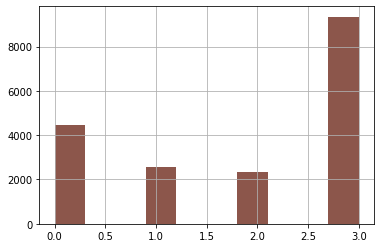

In [62]:
# cat_model = Catb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
lgb_model = Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
xgb_model = Xgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01305	valid_1's rmse: 1.03181
[200]	training's rmse: 0.945222	valid_1's rmse: 0.984044
[300]	training's rmse: 0.911401	valid_1's rmse: 0.968491
[400]	training's rmse: 0.888672	valid_1's rmse: 0.962504
[500]	training's rmse: 0.870158	valid_1's rmse: 0.959807
[600]	training's rmse: 0.854535	valid_1's rmse: 0.958539
[700]	training's rmse: 0.84055	valid_1's rmse: 0.957503
[800]	training's rmse: 0.827614	valid_1's rmse: 0.957132
[900]	training's rmse: 0.815627	valid_1's rmse: 0.957259
Early stopping, best iteration is:
[803]	training's rmse: 0.827204	valid_1's rmse: 0.957065
Partial score of fold 0 is: 0.5929414645971569
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01249	valid_1's rmse: 1.0395
[200]	training's rmse: 0.94475	valid_1's rmse: 0.992346
[300]	training's rmse: 0.91194	valid_1's rmse: 0.97736
[400]	training's rmse: 0.889299	valid_1's rmse: 0.970344
[500]	training's rmse: 0.870961	valid_1's rmse: 0.966998
[600]	training's rmse: 0.855208	valid_1's rmse: 0.965146
[700]	training's rmse: 0.840887	valid_1's rmse: 0.964
[800]	training's rmse: 0.82792	valid_1's rmse: 0.963541
[900]	training's rmse: 0.815865	valid_1's rmse: 0.963003
[1000]	training's rmse: 0.804572	valid_1's rmse: 0.962553
[1100]	training's rmse: 0.793784	valid_1's rmse: 0.962354
Early stopping, best iteration is:
[1062]	training's rmse: 0.797796	valid_1's rmse: 0.962251
Partial score of fold 1 is: 0.6000106301954551
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01729	valid_1's rmse: 1.02876
[200]	training's rmse: 0.949928	valid_1's rmse: 0.974635
[300]	training's rmse: 0.917069	valid_1's rmse: 0.956151
[400]	training's rmse: 0.894212	valid_1's rmse: 0.948547
[500]	training's rmse: 0.876171	valid_1's rmse: 0.945127
[600]	training's rmse: 0.860469	valid_1's rmse: 0.943162
[700]	training's rmse: 0.846484	valid_1's rmse: 0.941769
[800]	training's rmse: 0.83338	valid_1's rmse: 0.941282
[900]	training's rmse: 0.821001	valid_1's rmse: 0.940844
[1000]	training's rmse: 0.80934	valid_1's rmse: 0.940817
Early stopping, best iteration is:
[955]	training's rmse: 0.814463	valid_1's rmse: 0.940695
Partial score of fold 2 is: 0.6215984724446693
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01168	valid_1's rmse: 1.03453
[200]	training's rmse: 0.944654	valid_1's rmse: 0.987451
[300]	training's rmse: 0.912303	valid_1's rmse: 0.971961
[400]	training's rmse: 0.889723	valid_1's rmse: 0.964749
[500]	training's rmse: 0.871475	valid_1's rmse: 0.961265
[600]	training's rmse: 0.855809	valid_1's rmse: 0.958868
[700]	training's rmse: 0.841751	valid_1's rmse: 0.957513
[800]	training's rmse: 0.828822	valid_1's rmse: 0.956187
[900]	training's rmse: 0.816566	valid_1's rmse: 0.95549
[1000]	training's rmse: 0.805144	valid_1's rmse: 0.955214
[1100]	training's rmse: 0.794316	valid_1's rmse: 0.954884
Early stopping, best iteration is:
[1075]	training's rmse: 0.796979	valid_1's rmse: 0.954803
Partial score of fold 3 is: 0.6076124342224567
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01306	valid_1's rmse: 1.03289
[200]	training's rmse: 0.944512	valid_1's rmse: 0.985525
[300]	training's rmse: 0.911071	valid_1's rmse: 0.97214
[400]	training's rmse: 0.888318	valid_1's rmse: 0.966954
[500]	training's rmse: 0.869991	valid_1's rmse: 0.964468
[600]	training's rmse: 0.854081	valid_1's rmse: 0.96294
[700]	training's rmse: 0.839852	valid_1's rmse: 0.962457
[800]	training's rmse: 0.826981	valid_1's rmse: 0.962594
Early stopping, best iteration is:
[715]	training's rmse: 0.837874	valid_1's rmse: 0.96232
Partial score of fold 4 is: 0.5944376294904521
Our oof cohen kappa score is:  0.6025067808669881
[0]	train-rmse:1.8343	val-rmse:1.83576
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[100]	train-rmse:0.990514	val-rmse:1.14397
[200]	train-rmse:0.708751	val-rmse:1.00378
[300]	train-rmse:0.593842	val-rmse:0.980222
[400]	train-rmse:0.532215	val-rmse:0.976547
[500]	train-rmse:0.493079	val-rmse:0.976451
[600]	train-rmse:0.466239	val-rmse:0.976878
Stopping. Best iteration:
[509]	train-rmse:0.49042	val-rmse:0.976361

Partial score of fold 0 is: 0.5780717661210506
[0]	train-rmse:1.83433	val-rmse:1.8355
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.989351	val-rmse:1.14073
[200]	train-rmse:0.713247	val-rmse:1.00398
[300]	train-rmse:0.593934	val-rmse:0.980075
[400]	train-rmse:0.526608	val-rmse:0.975913
[500]	train-rmse:0.488021	val-rmse:0.975284
Stopping. Best iteration:
[472]	train-rmse:0.497045	val-rmse:0.975212

Partial score of fold 1 is: 0.5838636262366934
[0]	train-rmse:1.83452	val-rmse:1.83527
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.992766	val-rmse:1.12985
[200]	train-rmse:0.717236	val-rmse:0.986409
[300]	train-rmse:0.604476	val-rmse:0.961644
[400]	train-rmse:0.543962	val-rmse:0.958755
[500]	train-rmse:0.511792	val-rmse:0.958973
Stopping. Best iteration:
[414]	train-rmse:0.538348	val-rmse:0.958578

Partial score of fold 2 is: 0.5931657046042409
[0]	train-rmse:1.83445	val-rmse:1.83577
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.984832	val-rmse:1.12959
[200]	train-rmse:0.701668	val-rmse:0.987725
[300]	train-rmse:0.58585	val-rmse:0.965562
[400]	train-rmse:0.525423	val-rmse:0.962632
[500]	train-rmse:0.487095	val-rmse:0.962826
Stopping. Best iteration:
[403]	train-rmse:0.523978	val-rmse:0.962597

Partial score of fold 3 is: 0.5919871575539102
[0]	train-rmse:1.83455	val-rmse:1.83526
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.988696	val-rmse:1.13803
[200]	train-rmse:0.709556	val-rmse:0.998482
[300]	train-rmse:0.595364	val-rmse:0.974106
[400]	train-rmse:0.536609	val-rmse:0.971258
[500]	train-rmse:0.498554	val-rmse:0.972259
Stopping. Best iteration:
[411]	train-rmse:0.531903	val-rmse:0.971133

Partial score of fold 4 is: 0.5839058215568564
Our oof cohen kappa score is:  0.5862517587455798

(18690, 369)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               74000     
_________________________________________________________________
layer_normalization (LayerNo (None, 200)               400       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
layer_normalization_1 (Layer (None, 100)               200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0 

Epoch 24/100
14944/14952 [============================>.] - ETA: 0s - loss: 0.9268
Epoch 00024: val_loss did not improve from 1.00984
14952/14952 [==============================] - 2s 153us/sample - loss: 0.9266 - val_loss: 1.0266
Epoch 25/100
14944/14952 [============================>.] - ETA: 0s - loss: 0.9230
Epoch 00025: val_loss did not improve from 1.00984
14952/14952 [==============================] - 2s 150us/sample - loss: 0.9230 - val_loss: 1.0313
Epoch 26/100
14912/14952 [============================>.] - ETA: 0s - loss: 0.9000
Epoch 00026: val_loss did not improve from 1.00984
14952/14952 [==============================] - 2s 154us/sample - loss: 0.8994 - val_loss: 1.0168
Epoch 27/100
14720/14952 [============================>.] - ETA: 0s - loss: 0.9030
Epoch 00027: val_loss did not improve from 1.00984
14952/14952 [==============================] - 2s 149us/sample - loss: 0.9009 - val_loss: 1.0167
Epoch 28/100
14816/14952 [============================>.] - ETA: 0s - loss: 

Epoch 13/100
14944/14952 [============================>.] - ETA: 0s - loss: 1.0499
Epoch 00013: val_loss did not improve from 0.94258
14952/14952 [==============================] - 2s 157us/sample - loss: 1.0496 - val_loss: 0.9428
Epoch 14/100
14624/14952 [============================>.] - ETA: 0s - loss: 1.0292
Epoch 00014: val_loss improved from 0.94258 to 0.93786, saving model to nn_model.w8
14952/14952 [==============================] - 2s 157us/sample - loss: 1.0286 - val_loss: 0.9379
Epoch 15/100
14688/14952 [============================>.] - ETA: 0s - loss: 1.0191
Epoch 00015: val_loss improved from 0.93786 to 0.92774, saving model to nn_model.w8
14952/14952 [==============================] - 2s 152us/sample - loss: 1.0183 - val_loss: 0.9277
Epoch 16/100
14752/14952 [============================>.] - ETA: 0s - loss: 1.0236
Epoch 00016: val_loss did not improve from 0.92774
14952/14952 [==============================] - 2s 157us/sample - loss: 1.0254 - val_loss: 0.9282
Epoch 17/1

14752/14952 [============================>.] - ETA: 0s - loss: 0.8060
Epoch 00047: val_loss did not improve from 0.90225
14952/14952 [==============================] - 2s 156us/sample - loss: 0.8044 - val_loss: 0.9253
Epoch 48/100
14880/14952 [============================>.] - ETA: 0s - loss: 0.7908
Epoch 00048: val_loss did not improve from 0.90225
14952/14952 [==============================] - 2s 154us/sample - loss: 0.7896 - val_loss: 0.9314
Epoch 49/100
14784/14952 [============================>.] - ETA: 0s - loss: 0.8045
Epoch 00049: val_loss did not improve from 0.90225
14952/14952 [==============================] - 2s 156us/sample - loss: 0.8036 - val_loss: 0.9528
Epoch 50/100
14720/14952 [============================>.] - ETA: 0s - loss: 0.7859
Epoch 00050: val_loss did not improve from 0.90225
14952/14952 [==============================] - 2s 152us/sample - loss: 0.7867 - val_loss: 0.9385
Epoch 51/100
14688/14952 [============================>.] - ETA: 0s - loss: 0.7787
Epoch 

Epoch 15/100
14784/14952 [============================>.] - ETA: 0s - loss: 1.0057
Epoch 00015: val_loss improved from 1.00151 to 1.00147, saving model to nn_model.w8
14952/14952 [==============================] - 2s 153us/sample - loss: 1.0075 - val_loss: 1.0015
Epoch 16/100
14720/14952 [============================>.] - ETA: 0s - loss: 1.0043
Epoch 00016: val_loss did not improve from 1.00147
14952/14952 [==============================] - 2s 159us/sample - loss: 1.0015 - val_loss: 1.0124
Epoch 17/100
14848/14952 [============================>.] - ETA: 0s - loss: 0.9931
Epoch 00017: val_loss improved from 1.00147 to 1.00040, saving model to nn_model.w8
14952/14952 [==============================] - 2s 155us/sample - loss: 0.9938 - val_loss: 1.0004
Epoch 18/100
14944/14952 [============================>.] - ETA: 0s - loss: 0.9690
Epoch 00018: val_loss did not improve from 1.00040
14952/14952 [==============================] - 2s 157us/sample - loss: 0.9691 - val_loss: 1.0015
Epoch 19/1

Partial score of fold 2 is: 0.596369318326177
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 200)               74000     
_________________________________________________________________
layer_normalization_12 (Laye (None, 200)               400       
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               20100     
_________________________________________________________________
layer_normalization_13 (Laye (None, 100)               200       
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_17

14784/14952 [============================>.] - ETA: 0s - loss: 0.9333
Epoch 00025: val_loss did not improve from 0.94782
14952/14952 [==============================] - 2s 155us/sample - loss: 0.9334 - val_loss: 0.9494
Epoch 26/100
14944/14952 [============================>.] - ETA: 0s - loss: 0.9144
Epoch 00026: val_loss did not improve from 0.94782
14952/14952 [==============================] - 2s 154us/sample - loss: 0.9148 - val_loss: 0.9564
Epoch 27/100
14624/14952 [============================>.] - ETA: 0s - loss: 0.9174
Epoch 00027: val_loss did not improve from 0.94782
14952/14952 [==============================] - 2s 151us/sample - loss: 0.9181 - val_loss: 0.9662
Epoch 28/100
14848/14952 [============================>.] - ETA: 0s - loss: 0.9074
Epoch 00028: val_loss did not improve from 0.94782
14952/14952 [==============================] - 2s 152us/sample - loss: 0.9078 - val_loss: 0.9497
Epoch 29/100
14912/14952 [============================>.] - ETA: 0s - loss: 0.9023
Epoch 

Epoch 1/100
14624/14952 [============================>.] - ETA: 0s - loss: 1.8539
Epoch 00001: val_loss improved from inf to 1.11903, saving model to nn_model.w8
14952/14952 [==============================] - 3s 228us/sample - loss: 1.8435 - val_loss: 1.1190
Epoch 2/100
14816/14952 [============================>.] - ETA: 0s - loss: 1.3456
Epoch 00002: val_loss improved from 1.11903 to 1.08003, saving model to nn_model.w8
14952/14952 [==============================] - 2s 154us/sample - loss: 1.3443 - val_loss: 1.0800
Epoch 3/100
14752/14952 [============================>.] - ETA: 0s - loss: 1.2337
Epoch 00003: val_loss improved from 1.08003 to 1.05585, saving model to nn_model.w8
14952/14952 [==============================] - 2s 156us/sample - loss: 1.2311 - val_loss: 1.0558
Epoch 4/100
14624/14952 [============================>.] - ETA: 0s - loss: 1.1974
Epoch 00004: val_loss improved from 1.05585 to 1.04667, saving model to nn_model.w8
14952/14952 [==============================] - 2s

Epoch 35/100
14624/14952 [============================>.] - ETA: 0s - loss: 0.8591
Epoch 00035: val_loss did not improve from 0.97068
14952/14952 [==============================] - 2s 164us/sample - loss: 0.8634 - val_loss: 0.9774
Epoch 36/100
14912/14952 [============================>.] - ETA: 0s - loss: 0.8577
Epoch 00036: val_loss did not improve from 0.97068
14952/14952 [==============================] - 2s 160us/sample - loss: 0.8578 - val_loss: 0.9908
Epoch 37/100
14592/14952 [============================>.] - ETA: 0s - loss: 0.8600
Epoch 00037: val_loss did not improve from 0.97068
14952/14952 [==============================] - 2s 158us/sample - loss: 0.8587 - val_loss: 0.9950
Epoch 38/100
14880/14952 [============================>.] - ETA: 0s - loss: 0.8433
Epoch 00038: val_loss did not improve from 0.97068
14952/14952 [==============================] - 2s 158us/sample - loss: 0.8429 - val_loss: 0.9926
Partial score of fold 4 is: 0.5994950357577962
Our oof cohen kappa score is:

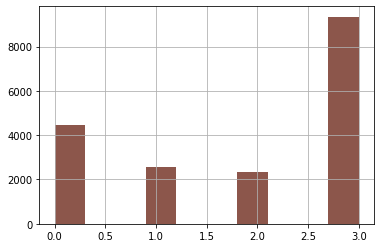

In [63]:
# cnn_model = Cnn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
nn_model = Nn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

In [65]:
weights = {'lbg': 0.5, 'cat': 0, 'xgb': 0.3, 'nn': 0.2}

final_pred =  (lgb_model.y_pred * weights['lbg']) + (xgb_model.y_pred * weights['xgb']) + (nn_model.y_pred * weights['nn'])
#final_pred = cnn_model.y_pred
print(final_pred.shape)

(1000,)


In [66]:
# pd.DataFrame([(round(a, 2), round(b, 2), round(c, 2), round(d, 2)) for a, b, c, d in zip(lgb_model.y_pred, cat_model.y_pred, xgb_model.y_pred, nn_model.y_pred)], columns=['lgb', 'cat', 'xgb', 'nn']).head(50)

In [67]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
import time
from collections import Counter
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
import eli5
import shap
from IPython.display import HTML
import json
import altair as alt
from category_encoders.ordinal import OrdinalEncoder
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from typing import List

import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics
from typing import Any
from itertools import product
pd.set_option('max_rows', 500)
import re
from tqdm import tqdm
from joblib import Parallel, delayed
from numba import jit


@jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


def eval_qwk_lgb(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """

    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return 'cappa', qwk(y_true, y_pred), True


def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred[y_pred <= 1.12232214] = 0
    y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
    y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
    y_pred[y_pred > 2.22506454] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'cappa', qwk(y_true, y_pred), True

Using TensorFlow backend.


In [68]:
from functools import partial
import scipy as sp

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']
    
    


In [69]:
lgb_model.model.predict(lgb_model.train_df[lgb_model.features])

array([2.18479015, 1.42525867, 2.24677907, ..., 2.37502231, 1.31257712,
       1.27104201])

In [70]:
%%time

# pr_train = (lgb_model.model.predict(lgb_model.train_df[lgb_model.features]) * 0.4).reshape(-1) + (nn_model.model.predict(nn_model.train_df[nn_model.features]) * 0.2).reshape(-1) + cat_model.model.predict(cat_model.train_df[cat_model.features]).reshape(-1) * 0.4
optR = OptimizedRounder()
# optR.fit(pr_train.reshape(-1), train_labels['accuracy_group'].values.reshape(-1))
optR.fit(final_pred, pseudolabels['accuracy_group'].values.reshape(-1))
bound = optR.coefficients()

CPU times: user 589 ms, sys: 7.95 ms, total: 597 ms
Wall time: 616 ms


In [71]:
bound

array([0.87627292, 1.71982265, 2.32343116])

In [72]:
for col in reduce_train.columns:
    if reduce_train[col].dtype == 'object':
        print(col)

installation_id


In [73]:
final_pred.reshape(-1).shape, train_labels['accuracy_group'].values.reshape(-1).shape

((1000,), (17690,))

In [ ]:
# bound = [1.12232214, 1.73925866, 2.22506454]

In [ ]:
def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred1 = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred1.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)

3    0.498
0    0.239
1    0.137
2    0.126